### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import random
import os

# Reproducibility
torch.manual_seed(42)
random.seed(42)

/home/datafoundry/anaconda3/envs/speechenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [2]:
# Load dataset
dataset = KarateClub()
data = dataset[0]
ground_truth_labels = data.y.clone() 

# Number of classes
num_classes = int(ground_truth_labels.max().item()) + 1

In [3]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [4]:
print(num_classes)

4


In [5]:
ground_truth_labels

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [6]:
len(ground_truth_labels)

34

### Train Test Split

In [7]:
num_nodes = data.num_nodes
indices = list(range(num_nodes))
random.shuffle(indices)

train_size = int(0.7 * num_nodes)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.test_mask = test_mask
data.y = ground_truth_labels 


In [8]:
data.train_mask

tensor([ True, False,  True, False, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True, False,  True,  True,  True, False,  True,  True,
        False, False,  True, False])

### Model Definition

In [28]:
import torch.nn.functional as F
from torch.nn import Dropout, BatchNorm1d

class DeeperGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        return x


### Model Training and saving

In [23]:
model = GCN(input_dim=data.num_node_features, hidden_dim=16, output_dim=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        pred = out.argmax(dim=1)
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / train_mask.sum().item()
        print(f"Epoch {epoch:>3} | Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}%")

# Save the model
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/gcn_karate.pth")
print("✅ Model saved to models/gcn_karate.pth")


Epoch   0 | Loss: 1.3620 | Train Acc: 30.43%
Epoch  20 | Loss: 0.7995 | Train Acc: 78.26%
Epoch  40 | Loss: 0.3760 | Train Acc: 91.30%
Epoch  60 | Loss: 0.1602 | Train Acc: 100.00%
Epoch  80 | Loss: 0.0729 | Train Acc: 100.00%
Epoch 100 | Loss: 0.0396 | Train Acc: 100.00%
Epoch 120 | Loss: 0.0245 | Train Acc: 100.00%
Epoch 140 | Loss: 0.0166 | Train Acc: 100.00%
Epoch 160 | Loss: 0.0120 | Train Acc: 100.00%
Epoch 180 | Loss: 0.0091 | Train Acc: 100.00%
✅ Model saved to models/gcn_karate.pth


### Loading Saved Model and Prediction

In [24]:
# Load the model
model_loaded = GCN(input_dim=data.num_node_features, hidden_dim=16, output_dim=num_classes)
model_loaded.load_state_dict(torch.load("models/gcn_karate.pth"))
model_loaded.eval()

# Prediction
with torch.no_grad():
    logits = model_loaded(data.x, data.edge_index)
    pred = logits.argmax(dim=1)
    test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / test_mask.sum().item()
    print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 90.91%


/tmp/ipykernel_255911/576852117.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load("models/gcn_karate.pth"))


### Test and Ground Truth Data Plot

In [25]:
from torch_geometric.utils import to_networkx
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG data to NetworkX graph
G = to_networkx(data, to_undirected=True)

In [26]:
def plot_test_predictions(G, labels, mask, title="Test Node Labels"):
    pos = nx.spring_layout(G, seed=42)
    

    node_colors = [-1] * G.number_of_nodes()
    for i, is_test in enumerate(mask):
        if is_test:
            node_colors[i] = labels[i].item()  

    plt.figure(figsize=(10, 10))
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=True,
        node_color=node_colors,
        cmap="tab10",
        node_size=700,
        font_size=12,
        edge_color="lightgray",
        vmin=0,  # minimum class label
        vmax=labels.max().item(),  # max class label
    )
    plt.title(title)
    plt.axis('off')
    plt.show()


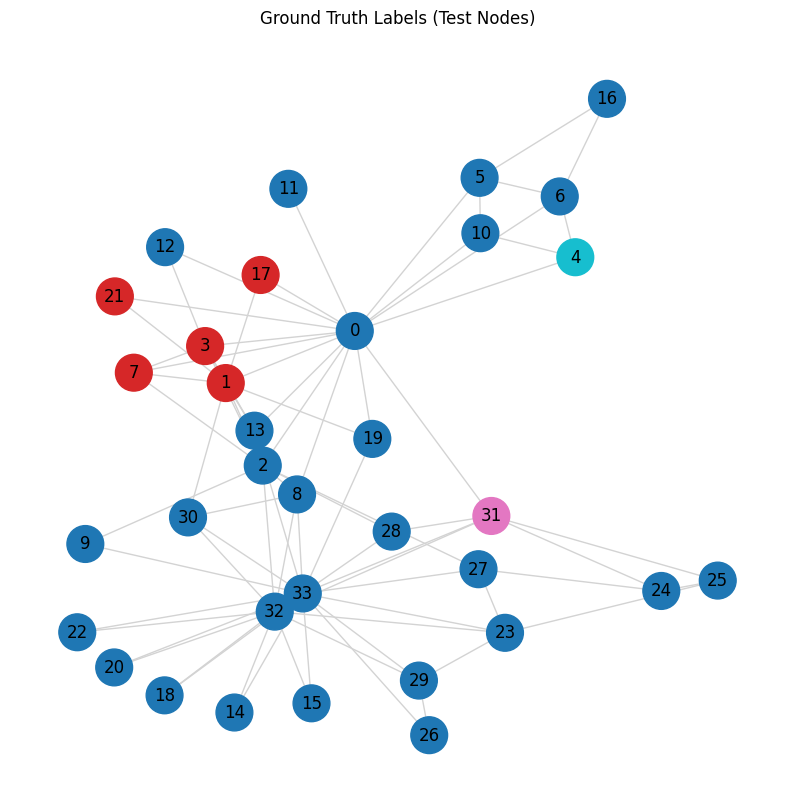

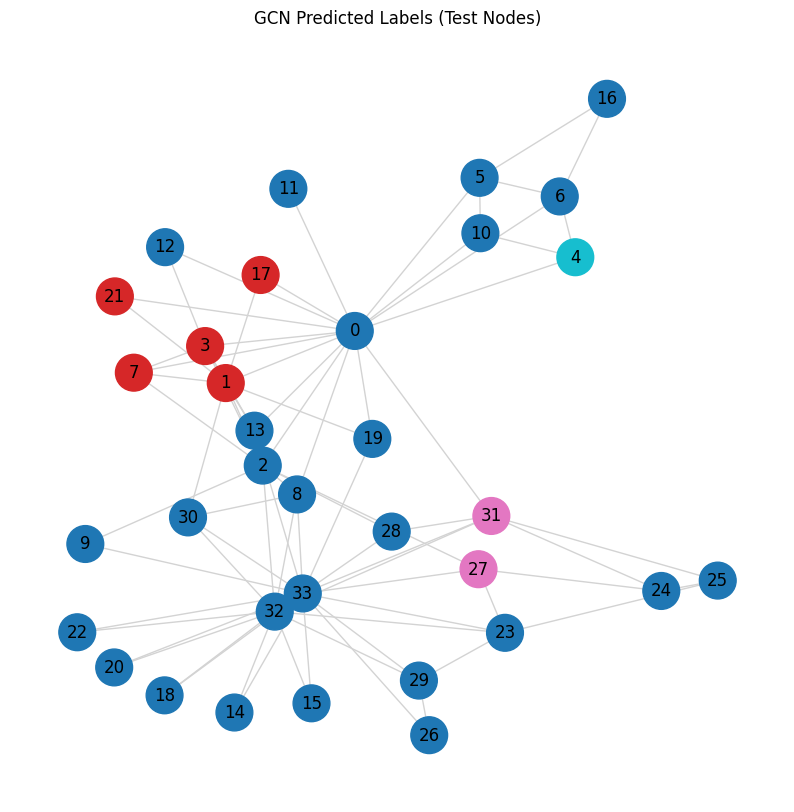

In [27]:
# Before training – show true test labels
plot_test_predictions(G, data.y, data.test_mask, title="Ground Truth Labels (Test Nodes)")

# After training – show model predictions
plot_test_predictions(G, pred, data.test_mask, title="GCN Predicted Labels (Test Nodes)")
